In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

#### Loading data

Dataset can be found here: http://www.nlpr.ia.ac.cn/databases/handwriting/Home.html

In [ ]:
images = np.load("/content/drive/My Drive/RealTimeMandarin/train_images.npy", allow_pickle=True)
labels = np.load("/content/drive/My Drive/RealTimeMandarin/train_labels.npy", allow_pickle=True)

In [0]:
val_images = np.load("/content/drive/My Drive/RealTimeMandarin/val_images.npy", allow_pickle=True)
val_labels = np.load("/content/drive/My Drive/RealTimeMandarin/val_labels.npy", allow_pickle=True)

In [0]:
test_images = np.load("/content/drive/My Drive/RealTimeMandarin/test_images.npy", allow_pickle=True)
test_labels = np.load("/content/drive/My Drive/RealTimeMandarin/test_labels.npy", allow_pickle=True)

#### Preprocessing

Images in the CASIA dataset are all of different sizes, therefore first resize all images to the same height/width using opencv (not shown here)

In [0]:
def resize_image(img, height=128, width=128):
    """
        Resizes image to the desired height and width
    """
    return cv2.resize(img, (height, width), interpolation=cv2.INTER_AREA)

Currently I'm starting out with ten characters that I have chosen from the dataset stored as a numpy array.

In [0]:
ten_classes = np.load("/content/drive/My Drive/RealTimeMandarin/10.npy").astype('int32')

In [0]:
selected_train = labels[np.where(np.isin(labels, ten_classes))].astype('int32')
selected_val = val_labels[np.where(np.isin(val_labels, ten_classes))].astype('int32')
selected_test = test_labels[np.where(np.isin(test_labels, ten_classes))].astype('int32')

val_images = val_images[selected_val]
val_labels = val_labels[selected_val]
images = images[selected_train]
labels = labels[selected_train]
test_images = test_images[selected_test]
test_labels = test_labels[selected_test]

In [0]:
labels = labels.astype('int32')
val_labels = val_labels.astype('int32')
test_labels = test_labels.astype('int32')

Since all the images were all different sizes, I recreate the numpy array and reshape to have 4-dimmensional data which is what the Convolutional Neural Network expects

In [0]:
train = []
val = []
test = []

for i in range(len(images)):
    train.append(images[i])

for i in range(len(test_images)):
    test.append(test_images[i])

for i in range(len(val_images)):
    val.append(val_images[i])
    
X_train = np.concatenate(train).reshape(len(train), 128, 128, 1)
X_val = np.concatenate(val).reshape(len(val), 128, 128, 1)
X_test = np.concatenate(test).reshape(len(test), 128, 128, 1)

Normalize the input between 0 and 1

In [0]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

Example of an image found in the dataset

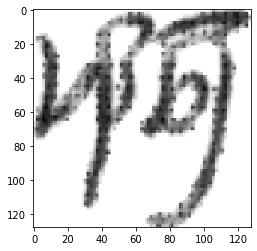

In [0]:
plt.imshow(X_train[2100].reshape(128, 128), cmap='gray')
plt.show()

One Hot Encode labels

In [0]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

ohe.fit(labels.reshape(-1, 1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

I store the One Hot encoder which is useful for debugging later

In [0]:
import pickle
with open('/content/drive/My Drive/RealTimeMandarin/ohe_ten_classes.save', "wb") as f:
    pickle.dump(ohe, f)

In [0]:
y_train = ohe.transform(labels.reshape(-1, 1))
y_test = ohe.transform(test_labels.reshape(-1, 1))
y_val = ohe.transform(val_labels.reshape(-1, 1))

#### Training

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(rate=0.25))
model.add(Dense(256))
model.add(Dropout(rate=0.25))
model.add(Dense(10, activation='softmax'))

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

In [0]:
# early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=1, batch_size=256, callbacks=[es])

Train on 2153 samples, validate on 238 samples
Epoch 1/100
2153/2153 [==============================] - 2s 739us/step - loss: 6.0670 - acc: 0.1677 - val_loss: 2.0720 - val_acc: 0.6639
Epoch 2/100
2153/2153 [==============================] - 1s 271us/step - loss: 1.8355 - acc: 0.7176 - val_loss: 1.3956 - val_acc: 0.7899
Epoch 3/100
2153/2153 [==============================] - 1s 272us/step - loss: 1.1640 - acc: 0.8040 - val_loss: 0.7375 - val_acc: 0.8739
Epoch 4/100
2153/2153 [==============================] - 1s 276us/step - loss: 0.6244 - acc: 0.8788 - val_loss: 0.4069 - val_acc: 0.9076
Epoch 5/100
2153/2153 [==============================] - 1s 282us/step - loss: 0.3647 - acc: 0.9043 - val_loss: 0.2831 - val_acc: 0.9160
Epoch 6/100
2153/2153 [==============================] - 1s 277us/step - loss: 0.2364 - acc: 0.9322 - val_loss: 0.2344 - val_acc: 0.9244
Epoch 7/100
2153/2153 [==============================] - 1s 270us/step - loss: 0.1556 - acc: 0.9610 - val_loss: 0.2143 - val_acc: 0

In [0]:
model.evaluate(X_test, y_test)

600/600 [==============================] - 0s 232us/step


[0.31913396100203195, 0.9116666674613952]